# Pytorch Neural Network Starter
## About this notebook
*  This notebook is basic code for neural network starter using pytorch including Kfold, label encoding, one-hot encoding and so on.
*  This notebook is detail version in order to understand easily. Short version will be made.
*  If this is helpful for you, please upvote.



*  このノートブックは、NaNの処理、Kfold, ラベルエンコーディング、ワンホットエンコーディングなどの様々な場面で使うコードを含む、pytorchのニューラルネットワークの基礎コードです。
*  理解を深めるために、長く書いています。ショートバージョンも作ります。
*  もし、お役に立ちましたら、upvoteしてくれると嬉しいです。



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,Dataset

import gc

import random

import transformers
import warnings
warnings.simplefilter('ignore')

#scaler = torch.cuda.amp.GradScaler() # GPUでの高速化。

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cpuがgpuかを自動判断
device

# Fixing Random seed in order to get reproducability. 再現性確保のためのランダムシード固定

In [ ]:
SEED = 508

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

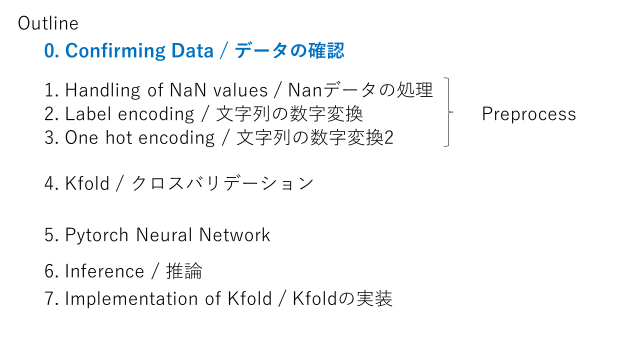

# 0. Confirming the train/test data : データの確認


In [ ]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df

In [ ]:
test = pd.read_csv("../input/titanic/test.csv")
test

## About data
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

#########日本語#################

survival	生死	0 = 死亡, 1 = 生存
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	性別	
Age	年齢	
sibsp	# of siblings / 親族の数	
parch	# of parents / 子供の数	
ticket	Ticket number　チケットナンバー	
fare	Passenger fare	運賃
cabin	Cabin number	部屋の番号
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton　乗船した場所


In [ ]:
df.info()

#### There are 891 rows. There are NaN data in Age, Cabin, Embarked.
#### 全部で891行あって、Age,Cabin,Embarkedにはnullデータはないが、NaNデータがありそう。

In [ ]:
df.columns

In [ ]:
for col in df.columns:
    print(str(col) + ":" + str(len(df[col].unique())))

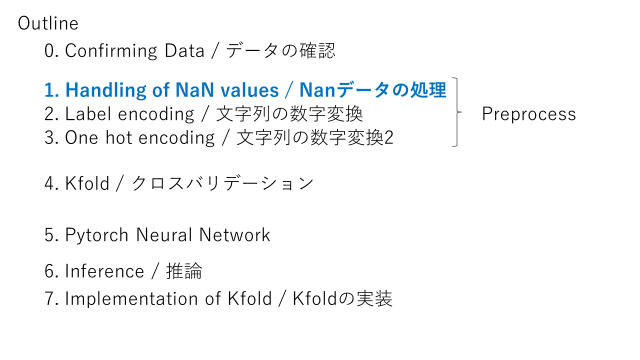

# 1. Handling of NaN values : 欠損値の処理
### 1.1 filling an mean value. : 平均値で埋める

In [ ]:
df["Age"]

In [ ]:
# In order to get the average value, dropna is used to remove all but Nan data.
# 平均値を出すために、dropnaでNanデータ以外を抜きます。
df["Age"].dropna()

In [ ]:
dmean = df["Age"].dropna().mean()
dmean

In [ ]:
# filling an mean value. : 平均値で埋める

df["Age"] = df["Age"].fillna(dmean)

In [ ]:
df

In [ ]:
test["Age"] = test["Age"].fillna(dmean)

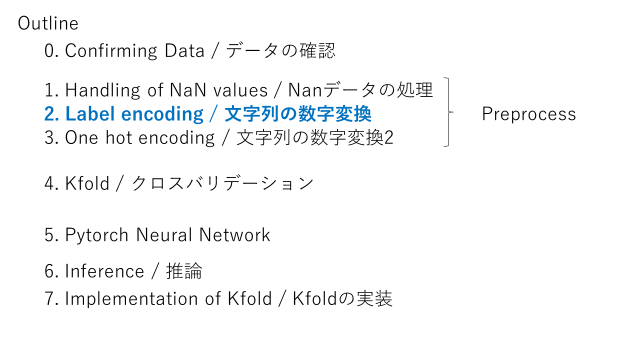

# 2 label encoding
#### Automatically convert strings to numbers. Since there is a significant difference such as 0 and 1, Sex is divided in this way.
#### 文字列を数字に自動変換. 0と1など有意差があるため、このやり方で性別を分けています。

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()
le.fit(df["Sex"])
df["Sex"] = le.transform(df["Sex"])
test["Sex"] = le.transform(test["Sex"])

In [ ]:
df

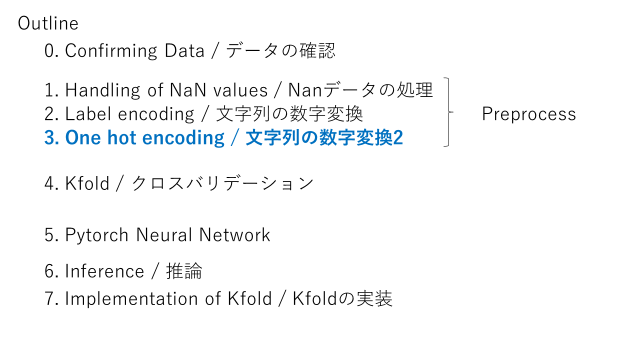

# 3. One-hot encoding
#### Automatically convert strings to numbers line by line. 
#### There are four Embarked places including NaN, but since no significant difference can be considered, divide them in parallel.
#### 文字列を行ごとに数字に自動変換。EmbarkedはNaNを入れて4つあるが、有意差が考えられないので、並列に分けます。

In [ ]:
# firstly, combining df and test. Combine vertically with axis = 0.
# トレインデータとテストデータを結合します。axis = 0 で縦に結合。

dfall = pd.concat([df,test],axis=0)
dfall

In [ ]:
# one-hot encoding using pd.get_dummies. NaN can also be separated by dummy_na = True.
# get_dummiesを使って、one-hot encodingします。dummy_na=TrueでNaNも分けることが可能。

dfall2 = pd.get_dummies(dfall["Embarked"],dummy_na=True)
dfall2

In [ ]:
# Combine horizontally with axis = 1.
# axis = 1 で横に結合。

dfall = pd.concat([dfall,dfall2],axis=1)
dfall

In [ ]:
# Separate the train data and test data and restore them.
# トレインデータとテストデータに分離して元に戻します。

train = dfall.iloc[:len(df),:]
test = dfall.iloc[len(df):,:]

In [ ]:
train

In [ ]:
test

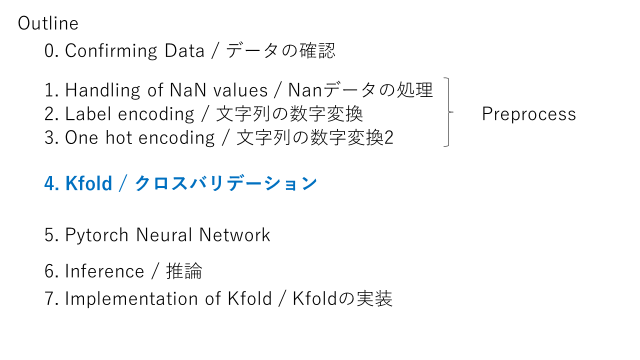

# 4. Kfold
#### Prepare training data and verification data in 5 combinations.
#### 訓練データと検証データを5つの組み合わせで準備する。

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["Survived"])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', "Survived"]).size())

In [ ]:
folds

## for practice, fold0 is defined as validation, fold1-4 are defined as train
## 練習のために、まず、fold0を検証データ、fold1-4を訓練データとします。

In [ ]:
p_train = folds[folds["fold"] != 0]
p_val = folds[folds["fold"] == 0]

In [ ]:
p_train

In [ ]:
# An error will occur later, so reassign the index.
# 後ほどエラーが出るので、indexを振りなおす。

p_train = p_train.reset_index(drop=True)
p_val = p_val.reset_index(drop=True)

In [ ]:
p_train

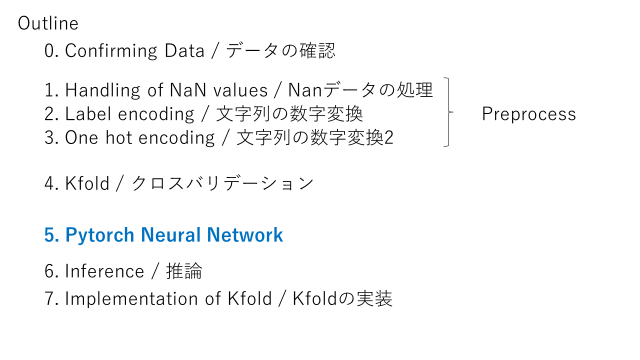

# 5.Neural Network using pytorch

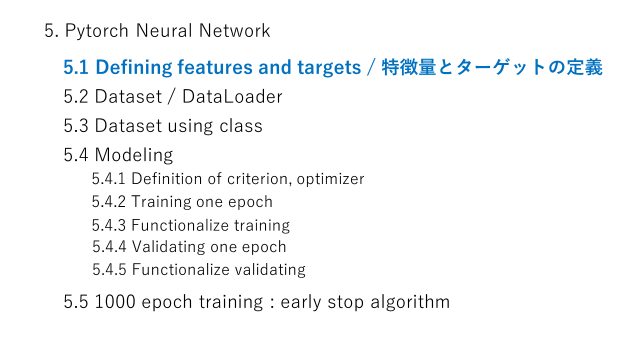

# 5.1 Defining features and target
##     特徴量とラベル(ターゲット)を定義します

In [ ]:
# defining the feature columns and the target

FEATURES = ["Pclass","Sex","Age","SibSp","Parch","C","Q","S",np.nan]
TARGET = "Survived"

In [ ]:
p_train[FEATURES]

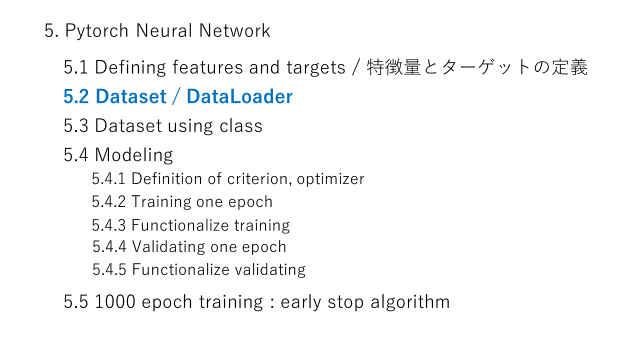

# 5.2 Dataset/DataLoader
## Dataset : Set the combination of features and correct answers.　
#### → 特徴量と正解の組み合わせをセットします。イメージでいうと、1つのビニール袋の中に特徴量1個と正解1個を入れるイメージ（これが1行分)。


## 5.2.1 まずは1つやってみる 

In [ ]:
p_train[FEATURES]

In [ ]:
p_train[TARGET]

#### 5.2.1.1 DataFrame → Numpy

In [ ]:
train_X = np.array(p_train[FEATURES])
train_Y = np.array(p_train[TARGET])

val_X = np.array(p_val[FEATURES])
val_Y = np.array(p_val[TARGET])

In [ ]:
train_X[:3]

#### 5.2.1.2 Numpy → Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
Normarizescaler = StandardScaler()
Normarizescaler.fit(np.array(train[FEATURES]))

In [ ]:
train_X = Normarizescaler.transform(train_X)
val_X = Normarizescaler.transform(val_X)

In [ ]:
train_X[:3]

#### 5.2.1.4 Normalization → torch

In [ ]:
train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).long() # long : int64

val_X = torch.from_numpy(val_X).float()
val_Y = torch.from_numpy(val_Y).long() # long : int64

In [ ]:
train_X[:3]

#### 5.2.1.5 Tensor Dataset

In [ ]:
train_dataset = TensorDataset(train_X,train_Y)
val_dataset = TensorDataset(val_X,val_Y)

In [ ]:
train_dataset[0]

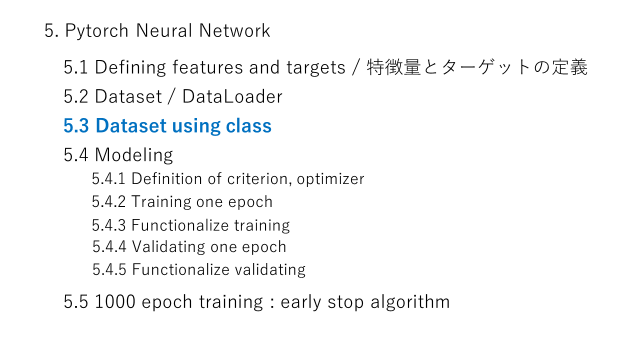

# 5.3 Making class : In Pytorch, when creating a Dataset, it is often created as a class as shown below. Therefore, I will explain how to do this.

Pytorchでは、よくDatasetを作るときに以下のように、classにして作成することが多いです。そのため、このやり方を説明します。

In [ ]:
class PytorchDataSet(Dataset):
    
    def __init__(self,df):
        
        # for test data, In test data, it's easier to fill it with something on purpose.
        # テストデータも読み込めるようにわざと9999で埋めています。
        
        if "Survived" not in df.columns:
            df["Survived"] = 9999
        
        self.df = df
        
        self.train_X = np.array(self.df[FEATURES])
        self.train_Y = np.array(self.df[TARGET])
        
        self.train_X = Normarizescaler.transform(self.train_X)
        
        self.train_X = torch.from_numpy(self.train_X).float()
        self.train_Y = torch.from_numpy(self.train_Y).long() # long : int64

    def __len__(self):
        
        return len(self.df)
    
    def __getitem__(self,idx):
        
        return {"X":self.train_X[idx],"Y":self.train_Y[idx]}

In [ ]:
train_dataset = PytorchDataSet(p_train)
val_dataset = PytorchDataSet(p_val)
test_dataset = PytorchDataSet(test)

In [ ]:
train[FEATURES].head(3)

You can see that the feature amount on the 0th line and the label are combined.


0行目の特徴量とlabelの組み合わせができていることがわかる

## Dataloader : Change the Dataset to a batch processing (multiple processing) format.
#### → Datasetをバッチ処理(複数処理)するフォーマットに変えます。Dataloaderは、Datasetで作った1つの袋を大きな紙袋に入れて、紙袋ごと処理するイメージ。この場合、1つの紙袋(Dataloader)には、trainingでは256個のビニール袋を詰め込むイメージ。

In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=256,shuffle = True)
val_dataloader = DataLoader(val_dataset,batch_size=256*2,shuffle = False)
test_dataloader = DataLoader(test_dataset,batch_size=256*2,shuffle = False)

In [ ]:
for a in train_dataloader:
    print(a)
    break

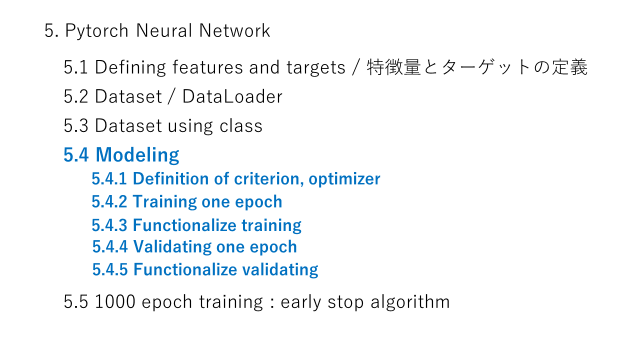

# 5.4 Modeling

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() 
        self.fc1 = nn.Linear(len(FEATURES),512) #input number and middle layer fc1
        self.fc2 = nn.Linear(512,256) # middle layer fc2
        self.fc3 = nn.Linear(256,2) # output
        
    
    def forward(self,x): 
        x= F.relu(self.fc1(x)) # Put the relu function after fc1
        x= F.relu(self.fc2(x)) # Put the relu function after fc2
        x = self.fc3(x) # fc3
        return x 

## 5.4.1 Definition of Criterion, optimizer

In [ ]:
model=Net() # model instance

model.to(device) # if GPU is using, this must be needed. cpu is also OK in this sentence.

criterion = nn.CrossEntropyLoss() # how to calculate loss function

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Algo for optimizing weight

In [ ]:
model

## 5.4.2 Training one epoch

In [ ]:
total_loss = 0 # Initializing total loss

model.train()

for a in train_dataloader:

        train_x= a["X"].to(device)
        train_y = a["Y"].to(device)
        
        
        optimizer.zero_grad() # Set the gradient of optimizer to 0

        output = model(train_x) # prediction
        
        loss = criterion(output,train_y) # calculationg loss between predictions and answers
        
        loss.backward() # backward

        optimizer.step() # optimizing weight

        total_loss += loss.item() # integration of loss
        
        break

In [ ]:
output[:3]

In [ ]:
torch.max(output.data,1)

In [ ]:
torch.max(output.data,1)[1]

## In numpy case, I use this method. ※ This is different in torch ⇔ numpy

In [ ]:
output_numpy = output.detach().cpu().numpy() # torch to numpy

In [ ]:
out2 = [s.argmax() for s in output_numpy] 

In [ ]:
out2[:20]

In [ ]:
total_loss

## 5.4.3 Functionalized for 1epoch

In [ ]:
def training(train_dataloader,model):

    total_loss = 0 # Initializing total loss
    
    model.train()

    for a in train_dataloader:

            train_x= a["X"].to(device)
            train_y = a["Y"].to(device)
            
            optimizer.zero_grad() # Set the gradient of optimizer to 0

            output = model(train_x) # prediction

            loss = criterion(output,train_y) # calculationg loss between predictions and answers

            loss.backward() # backward

            optimizer.step() # optimizing weight

            total_loss += loss.item() # integration of loss
            
    total_loss = total_loss/len(train_dataloader)
            
    return model,total_loss
        

In [ ]:
model,total_loss = training(train_dataloader,model)

In [ ]:
total_loss

## 5.4.4 validation

In [ ]:
total_loss = 0 # Initializing total loss

model.eval()

for a in val_dataloader:
    
    with torch.no_grad():
        

        val_x= a["X"].to(device)
        val_y = a["Y"].to(device)
        
        output = model(val_x) # prediction
        
        loss = criterion(output,val_y) # calculationg loss between predictions and answers
        
     
        total_loss += loss.item() # integration of loss
        
        break

In [ ]:
output[:3]

## 5.4.5 Functionalized for 1epoch

In [ ]:
def valeval(val_dataloader,model):
    
    allpreds=[]

    total_loss = 0 # Initializing total loss

    model.eval()

    for a in val_dataloader:

        with torch.no_grad():


            val_x= a["X"].to(device)
            val_y = a["Y"].to(device)

            output = model(val_x) # prediction
            
            allpreds.append(output.detach().cpu().numpy())
            
            loss = criterion(output,val_y) # calculationg loss between predictions and answers


            total_loss += loss.item() # integration of loss
            

    total_loss=total_loss/len(val_dataloader)
    allpreds = np.concatenate(allpreds)
    
    
    return allpreds, total_loss


In [ ]:
allpreds,valloss = valeval(val_dataloader,model)

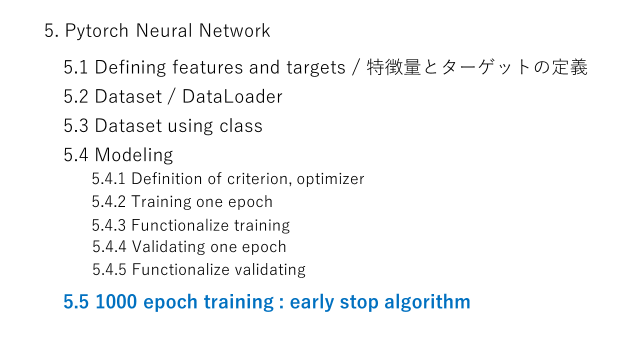

# 5.5     (test) 1000 epoch training and confirm

Initialize model condition

In [ ]:
model=Net() # model instance
model.to(device)

criterion = nn.CrossEntropyLoss() # how to calculate loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Algo for optimizing weight

In [ ]:
all_res = []

for epoch in tqdm(range(1000)):
    
    model,trainloss = training(train_dataloader,model)
    allpreds,valloss = valeval(val_dataloader,model)
    all_res.append([epoch,trainloss,valloss])
 

In [ ]:
alldf = pd.DataFrame(all_res)
alldf.columns = ["epoch","trainloss","valloss"]
alldf

In [ ]:
alldf.head(10)

In [ ]:
plt.plot(alldf["epoch"],alldf["trainloss"])
plt.plot(alldf["epoch"],alldf["valloss"])

## point : early stopping is needed in order to avoid overfitting 

### Accuracy score

In [ ]:
train_X

In [ ]:
train_preds = model(train_X)
train_preds

In [ ]:
train_preds2 = torch.max(train_preds.data,1)[1]
train_preds2[:3]

## python has already Accuracy function

In [ ]:
accuracy_score(train_Y,train_preds2)

In [ ]:
# functionalize

def calc_accuracy(x,y,model):
    preds = model(x)
    preds2 = torch.max(preds.data,1)[1]
    return accuracy_score(y,preds2)
    
    

In [ ]:
calc_accuracy(train_X,train_Y,model)

In [ ]:
calc_accuracy(val_X,val_Y,model)

In [ ]:
len(train_X)

## Strategy: Save model on best validation score update using calc_accuracy

In [ ]:
all_trainloss = []
all_valloss = []

all_trainscore = []
all_valscore = []

allres=[]

bestscore = 0

model=Net() # model instance

criterion = nn.CrossEntropyLoss() # how to calculate loss function

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Algo for optimizing weight

for epoch in tqdm(range(1000)):
    
    model,trainloss = training(train_dataloader,model)
    
    preds,valloss = valeval(val_dataloader,model)
    
    trainscore = calc_accuracy(train_X,train_Y,model)
    
    valscore = calc_accuracy(val_X,val_Y,model)
    
    allres.append([epoch,trainloss,valloss,trainscore,valscore])
    
    if bestscore <valscore:
        
        bestscore = valscore
        state = {
                    'state_dict': model.state_dict(),
                    'optimizer_dict': optimizer.state_dict(),
                    "bestscore":bestscore
                }
        

        torch.save(state, "model1.pth")
        
    else:
        pass
        
    
    

In [ ]:
bestscore

In [ ]:
resdf = pd.DataFrame(allres)
resdf.columns=["epoch","trainloss","valloss","trainscore","valscore"]

In [ ]:
resdf

In [ ]:
plt.plot(resdf["epoch"],resdf["trainloss"])
plt.plot(resdf["epoch"],resdf["valloss"])

In [ ]:
plt.plot(resdf["epoch"],resdf["trainscore"])
plt.plot(resdf["epoch"],resdf["valscore"])

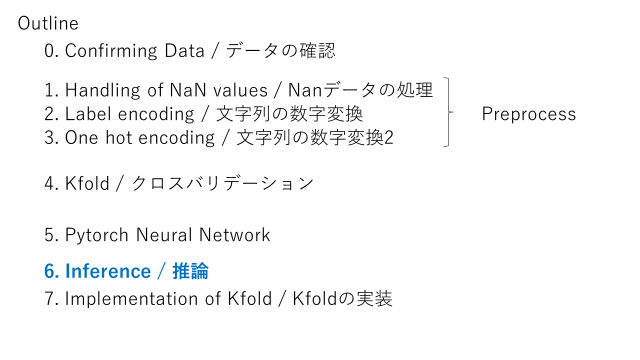

# 6.inference for test data

## 6.1 loading model

In [ ]:
state = torch.load("./model1.pth")

In [ ]:
model.load_state_dict(state["state_dict"])

In [ ]:
# confirming submission file

In [ ]:
submission = pd.read_csv("../input/titanic/gender_submission.csv")
submission

In [ ]:
for a in test_dataloader:
    print(a)
    break

In [ ]:
def inference(test_dataloader,model):
    
    allpreds=[]

    total_loss = 0 # Initializing total loss

    model.eval()

    for a in test_dataloader:

        with torch.no_grad():
            val_x= a["X"].to(device)
            val_y = a["Y"].to(device)

            output = model(val_x) # prediction
            
            allpreds.append(output.detach().cpu().numpy())
            
            

    allpreds = np.concatenate(allpreds)
    
    
    return allpreds


In [ ]:
allpreds = inference(test_dataloader,model)

In [ ]:
allpreds[:3]

In [ ]:
allpreds2 = [s.argmax() for s in allpreds]

In [ ]:
submission.head(3)

In [ ]:
submission["Survived"] = allpreds2

In [ ]:
submission.to_csv("submission1.csv",index = False)

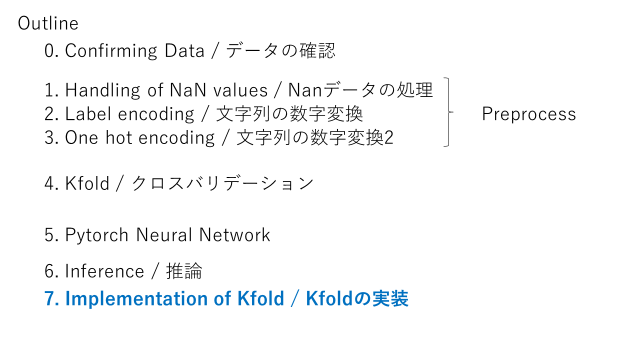

# 7. Application : Kfold

In [ ]:
kall_preds = []
bestscores=[]

for fold in range(5):
    
    print(f"----fold={fold}---start")


    p_train = folds[folds["fold"] != fold]
    p_val = folds[folds["fold"] == fold]

    # An error will occur later, so reassign the index.
    # 後ほどエラーが出るので、indexを振りなおす。

    p_train = p_train.reset_index(drop=True)
    p_val = p_val.reset_index(drop=True)

    train_dataset = PytorchDataSet(p_train)
    val_dataset = PytorchDataSet(p_val)
    test_dataset = PytorchDataSet(test)

    train_dataloader = DataLoader(train_dataset,batch_size=256,shuffle = True)
    val_dataloader = DataLoader(val_dataset,batch_size=256*2,shuffle = False)
    test_dataloader = DataLoader(test_dataset,batch_size=256*2,shuffle = False)

    model=Net() # model instance

    model.to(device) # if GPU is using, this must be needed. cpu is also OK in this sentence.

    criterion = nn.CrossEntropyLoss() # how to calculate loss function

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Algo for optimizing weight

    all_trainloss = []
    all_valloss = []

    all_trainscore = []
    all_valscore = []

    allres=[]

    bestscore = 0

    model=Net() # model instance

    criterion = nn.CrossEntropyLoss() # how to calculate loss function

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Algo for optimizing weight

    for epoch in tqdm(range(1000)):
        
        model,trainloss = training(train_dataloader,model)
        
        preds,valloss = valeval(val_dataloader,model)
        
        trainscore = calc_accuracy(train_X,train_Y,model)
        
        valscore = calc_accuracy(val_X,val_Y,model)
        
        allres.append([epoch,trainloss,valloss,trainscore,valscore])
        
        if bestscore <valscore:
            
            bestscore = valscore
            state = {
                        'state_dict': model.state_dict(),
                        'optimizer_dict': optimizer.state_dict(),
                        "bestscore":bestscore
                    }
            

            torch.save(state, f"model{fold}.pth")
            
        else:
            pass
            
    bestscores.append(bestscore)

## 7.1 Kfold inference ( this part can be included in #7 )

In [ ]:
kall_preds = []

for fold in range(5):
    
    state = torch.load(f"./model{fold}.pth")

    model.load_state_dict(state["state_dict"])

    allpreds = inference(test_dataloader,model)
    
    kall_preds.append(allpreds)
    
    

In [ ]:
bestscores

In [ ]:
np.mean(bestscores)

In [ ]:
len(kall_preds)

In [ ]:
kall_preds = np.mean(kall_preds,axis=0)
kall_preds = [s.argmax() for s in kall_preds]

In [ ]:
submission["Survived"] = kall_preds

In [ ]:
submission.to_csv("submission2.csv",index=False)

In [ ]:
submission